In [1]:
%reload_ext autoreload
%autoreload 2
import torch
from fastai.vision.all import *

In [18]:
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/Public/Desktop/wjt/disentanglement_lib/')
%env DISENTANGLEMENT_LIB_DATA=/data/disentanglement

env: DISENTANGLEMENT_LIB_DATA=/data/disentanglement


In [3]:
import wandb
api = wandb.Api()

In [283]:
from disentanglement_lib.visualize import visualize_model
from disentanglement_lib.evaluation.metrics import mig,factor_vae,dci,modularity_explicitness,sap_score,unified_scores
from disentanglement_lib.data.ground_truth import dsprites

In [5]:
from disentanglement_lib.utils.hub import *

In [284]:
data=dsprites.DSprites([1,2])

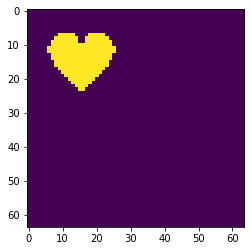

In [303]:
plt.imshow(data[17][0][0])

In [304]:
r = api.run("erow/dlib/13j2udpx")
r.url

'http://nbic-183:8080/erow/dlib/runs/13j2udpx'

In [305]:
model = get_model('tmp',device='cpu')
encoder,decoder = convert_model(model)

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [308]:
mu = torch.randn(10,10)
recon=sigmoid(decoder(mu)).squeeze(3)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [316]:
3*64*64

12288

In [312]:
F.binary_cross_entropy(torch.Tensor(recon[0]),torch.Tensor(recon[2]))*64*64

tensor(15147.9082)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


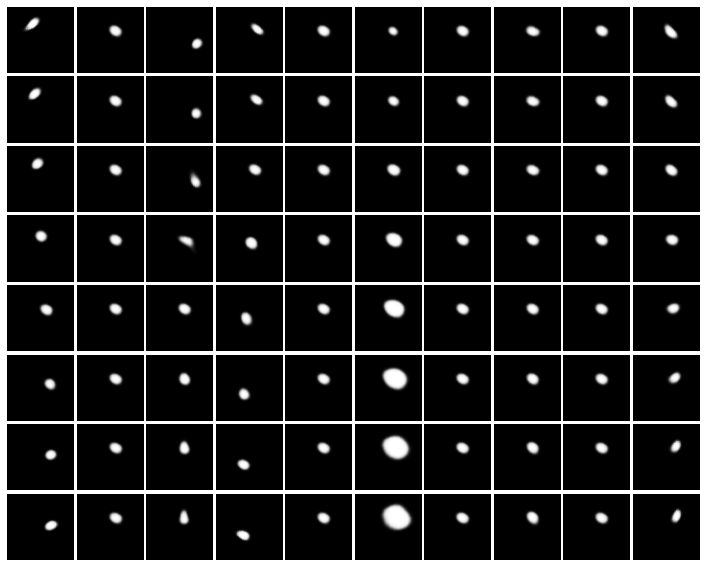

In [307]:
# from disentanglement_lib.visualize.visualize_util import *
mu = torch.randn(1,10)
plt_sample_traversal(mu,lambda x:sigmoid(decoder(x)).squeeze(3),8,range(7));

In [263]:
z_sampled = torch.zeros(1,10)
z_fake = torch.randn_like(z_sampled,requires_grad=True)

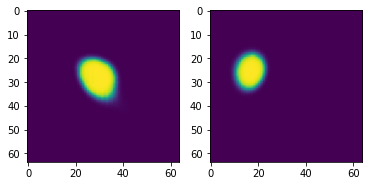

In [264]:
model.load_state_dict(torch.load("tmp/model.pt"))
pos_recons = model.decode(z_sampled)
neg_recons = model.decode(z_fake)
fig,axes=plt.subplots(1,2)
axes[0].imshow(pos_recons[0,0].sigmoid().data)
axes[1].imshow(neg_recons[0,0].sigmoid().data)

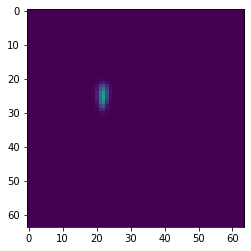

In [265]:
tp=(tp.data>0.5).float().clamp(1e-4,1-1e-4)
pp = pos_recons.sigmoid().clamp(1e-4,1-1e-4)
np = neg_recons.sigmoid().clamp(1e-4,1-1e-4).data
plt.imshow((pp*np)[0,0].data,vmax=1,vmin=0)

In [212]:
(tp+pp-pp*tp).sum()

tensor(219.0016, grad_fn=<SumBackward0>)

In [244]:
(pp*np).sum()

tensor(0.0136, grad_fn=<SumBackward0>)

In [278]:
from disentanglement_lib.methods.shared import losses
model.load_state_dict(torch.load("tmp/model.pt"))
opt=torch.optim.Adam(model.parameters(),1e-4)
for i in range(50):
    pos_recons = model.decode(z_sampled)
#     neg_recons = model.decode(z_fake)
    pp = pos_recons.sigmoid().clamp(1e-4,1-1e-4)
#     np = neg_recons.sigmoid().clamp(1e-4,1-1e-4).data
    inter = (pp*np).float()
    gap = (F.binary_cross_entropy(pp,1-np.data,reduction='none')*inter).sum()
    opt.zero_grad()
    gap.backward()
    opt.step()
    if i%10==0:
        print(gap.item())

5.417795181274414
0.3094319701194763
0.05729108676314354
0.033539462834596634
0.02927558124065399


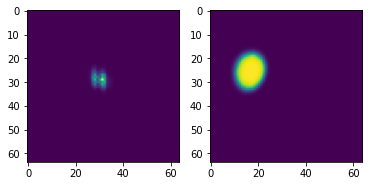

In [279]:
fig,axes=plt.subplots(1,2)
axes[0].imshow(pos_recons[0,0].sigmoid().data)
axes[1].imshow(neg_recons[0,0].sigmoid().data)

In [158]:
tp = pos_recons.clamp(1e-4,1-1e-4)
pp = pos_recons.sigmoid().clamp(1e-4,1-1e-4)
np = neg_recons.sigmoid().clamp(1e-4,1-1e-4)

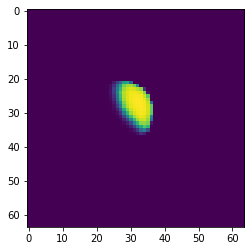

In [161]:
plt.imshow((inter_tpn).data[0,0])

In [165]:
F.binary_cross_entropy(pp,np.data,reduction='none').sum(),

(tensor(1812.1964, grad_fn=<SumBackward0>),
 tensor(61.7441, grad_fn=<SumBackward0>))

In [159]:
inter_tpn = tp * pp * np
inter_pt = tp * pp
inter_pn = np * pp

# pos_recon_loss = -torch.log(inter_pt).sum([1,2,3]).mean()
neg_recon_loss = -torch.log(1 - (inter_pn-inter_tpn)).sum([1,2,3]).mean()
pos_recon_loss,neg_recon_loss

(tensor(71976.7500, grad_fn=<NegBackward>),
 tensor(14.5636, grad_fn=<NegBackward>))

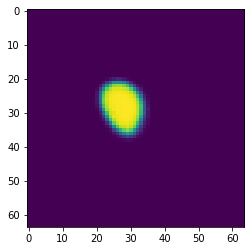

In [42]:
intersection = pos_recons.data.sigmoid() * neg_recons.sigmoid()
plt.imshow(intersection[0,0].data)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


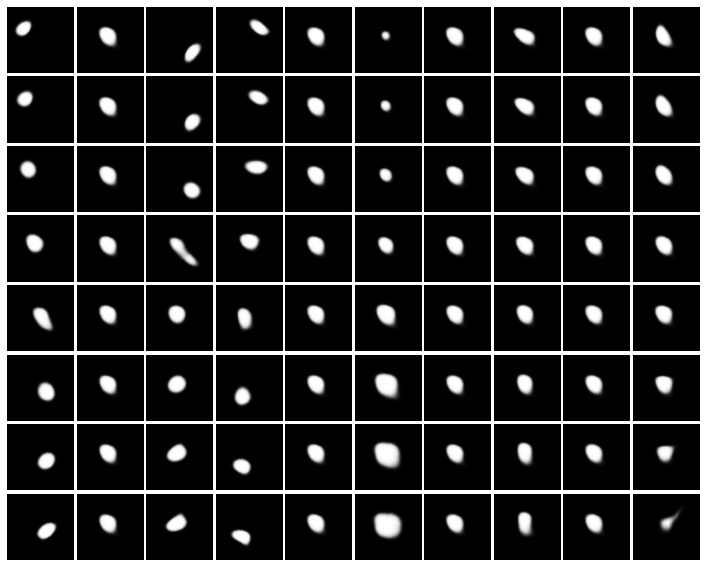

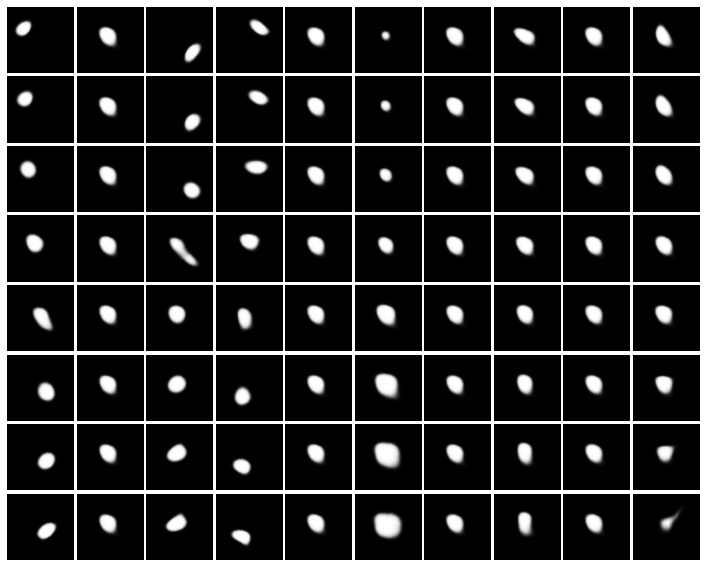

In [59]:
visualize_util.grid_save_images([pics], 'beta_traversal.png')

beta_traversal.png


In [61]:
mi=np.array(r.summary['discrete_mi'])

<AxesSubplot:>

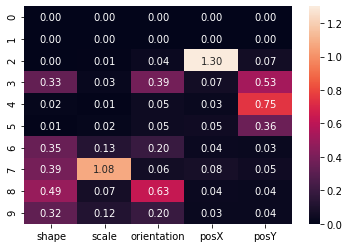

In [66]:
import seaborn as sns
sns.heatmap(mi,
            annot=True, fmt='.2f',
#             yticklabels=[0,0.1,0.3,0.5,1],
            xticklabels=['shape','scale','orientation','posX','posY'])

In [ ]:
for i in range(means.shape[1]):
    pics = activation(
        latent_traversal_1d_multi_dim(_decoder, means[i, :], None))
    file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
    

In [13]:
visualize_model.visualize_reconstructions(output_dir,dataset,recon_fn)

(64, 64, 64, 3) (64, 64, 64, 3)
visualization/reconstructions/reconstructions.jpg


In [14]:
visualize_model.visualize_samples(output_dir,num_latent,_decoder)

visualization/sampled/samples.jpg


In [15]:
visualize_model.visualize_traversal(output_dir,dataset,_encoder,_decoder)

visualization/traversals/traversals0.jpg
visualization/traversals/traversals1.jpg
visualization/traversals/traversals2.jpg
visualization/traversals/traversals3.jpg
visualization/traversals/traversals4.jpg
visualization/traversals/traversals5.jpg
visualization/traversals/traversals6.jpg
visualization/traversals/traversals7.jpg
visualization/traversals/traversals8.jpg
visualization/traversals/traversals9.jpg


In [16]:
visualize_model.visualize_intervention(output_dir, dataset, _encoder)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

In [52]:
from disentanglement_lib.visualize import visualize_scores

In [51]:
dataset.factor_names = ['shape','scale','orientation','posX','posY']
ans=unified_scores.compute_unified_scores(dataset,representation_fn,
                                          np.random.RandomState(), 'visualization', 10000,
        100, matrix_fns=[unified_scores.mutual_information_matrix])
ans

{'mutual_information_matrix.merge_0_1': 4.0,
 'mutual_information_matrix.merge_4_0': 5.0,
 'mutual_information_matrix.merge_4_1': 5.0,
 'mutual_information_matrix.merge_3_4': 6.0,
 'mutual_information_matrix.merge_3_0': 6.0,
 'mutual_information_matrix.merge_3_1': 6.0,
 'mutual_information_matrix.merge_2_3': 7.0,
 'mutual_information_matrix.merge_2_4': 7.0,
 'mutual_information_matrix.merge_2_0': 7.0,
 'mutual_information_matrix.merge_2_1': 7.0,
 'mutual_information_matrix.area_precision': 4.20109403969848,
 'mutual_information_matrix.max_precision': 3,
 'mutual_information_matrix.dci_disentanglement': 0.6076514748151725,
 'mutual_information_matrix.dci_completeness': 0.7406472747305626,
 'mutual_information_matrix.dci': 0.6076514748151725,
 'mutual_information_matrix.dci_disentanglement.code_0': 0.7809095938513819,
 'mutual_information_matrix.dci_disentanglement.code_1': 0.835017711339556,
 'mutual_information_matrix.dci_disentanglement.code_2': 3.415793203842554e-10,
 'mutual_informa

In [55]:
runs = api.runs("erow/fractionVAE",{"$and":[{"config.dataset":"dsprites_full"},
                                            {"config.base":"80,30,12"},
                                            {"config.beta":3},
                                           {"state":"finished"}]})
len(runs)

6

In [31]:
for file in r.files():
    if file.name.startswith('model-'):
        print(file)
        ans=defaultdict(list)
        representation_fn,model = get_representation_fn(r,r.config['img_size'],device='cpu',model_file=file.name)
        def _decoder(latent_vectors):
            with torch.no_grad():
                torch_imgs = model.decoder(torch.Tensor(latent_vectors)).numpy()
                return torch_imgs.transpose((0, 2, 3, 1))

        def _encoder(obs):
            with torch.no_grad():
                obs = torch.Tensor(obs.transpose((0, 3, 1, 2)))  # convert tf format to torch's
                mu, logvar = model.encoder(obs)
                mu, logvar = mu.numpy(), logvar.numpy()
                return mu, logvar
        visualize_model.visualize_intervention(output_dir, dataset, _encoder)
        name = file.name
        os.system(f'cp visualization/interventional_effects/interventional_effect.png visualization/interventional_effects/{name}.png')

<File model-1.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

<File model-11.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

<File model-13.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

<File model-15.pt () 15.0MiB>
<File model-17.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

<File model-19.pt () 15.0MiB>
<File model-3.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

<File model-5.pt () 15.0MiB>
<File model-7.pt () 15.0MiB>


/home/Public/notebooks/disentanglement/notebooks/disentanglement_lib/evaluation/metrics/irs.py:129: RuntimeWarning: invalid value encountered in true_divide
  normalized_deviations = cum_deviations / max_deviations[:, np.newaxis]
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slic

<File model-9.pt () 15.0MiB>


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pytorch/

In [30]:
name = "m1"
!cp visualization/interventional_effects/interventional_effect.png visualization/interventional_effects/$name.png

In [65]:
%matplotlib inline

5

In [36]:
for name in ['color_dsprites','scream_dsprites','smallnorb']:
    dataset = get_named_ground_truth_data(name)
    for i,n in enumerate(dataset.factors_num_values):
        num = min(n,6)
        factors = np.zeros([num,dataset.num_factors])
        factors[:,i] = np.linspace(0,n-1,num)
        images = dataset.sample_observations_from_factors(factors,np.random.RandomState())
        fig,axes=plt.subplots(1,num,figsize=(num,1),dpi=300)
        for img,ax in zip(images,axes):
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        fig.savefig(f'datasets/{name}_{i}.png',bbox_inches='tight',pad_inches=0)
    #     break
    fig

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


In [37]:
dataset.factors_num_values

[5, 9, 18, 6]

In [38]:
np.linspace(0.5,1,6)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])